<a href="https://colab.research.google.com/github/open-mmlab/mmsegmentation/blob/master/demo/MMSegmentation_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

## Train a semantic segmentation model on a new dataset

To train on a customized dataset, the following steps are necessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same prefix. To support a new dataset, we may need to modify the original file structure. 

In this tutorial, we give an example of converting the dataset. You may refer to [docs](https://github.com/open-mmlab/mmsegmentation/blob/master/docs/en/tutorials/customize_datasets.md#customize-datasets-by-reorganizing-data) for details about dataset reorganization. 

We use [Stanford Background Dataset](http://dags.stanford.edu/projects/scenedataset.html) as an example. The dataset contains 715 images chosen from existing public datasets [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) and [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/). Images from these datasets are mainly outdoor scenes, each containing approximately 320-by-240 pixels. 
In this tutorial, we use the region annotations as labels. There are 8 classes in total, i.e. sky, tree, road, grass, water, building, mountain, and foreground object. 

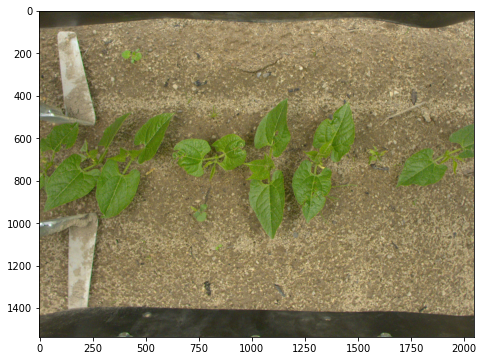

In [2]:
# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('../data/SMP2022/train/Training_Dev_2019_23_February/Bipbip/Bean/Images/Bipbip_haricot_im_00161.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

We need to convert the annotation into semantic map format as an image.

In [3]:
import os.path as osp
import numpy as np
from PIL import Image
# convert dataset annotation to semantic segmentation map
data_root = '../data/SMP2022/train/Training_Dev_2019_23_February/Bipbip/Bean'
img_dir = 'Images'
ann_dir = 'Masks'
# define class and plaette for better visualization
classes = ('background', 'background','crop', 'weed')
palette = [[0, 0, 0], [254, 124, 18], [255, 255, 255], [216, 67, 82]]

In [4]:
for file in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.regions.txt'):
  seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
  seg_img = Image.fromarray(seg_map).convert('P')
  seg_img.putpalette(np.array(palette, dtype=np.uint8))
  seg_img.save(osp.join(data_root, ann_dir, file.replace('.regions.txt', 
                                                         '.png')))

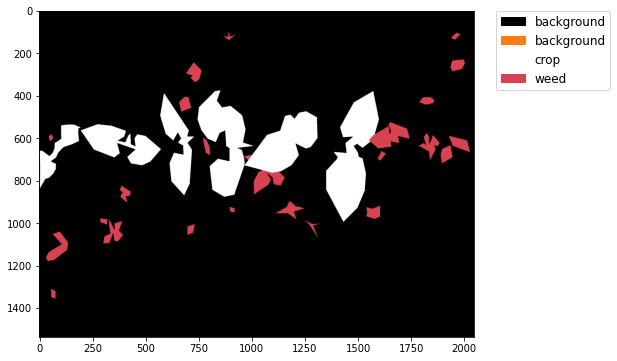

In [5]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('../data/SMP2022/train/Training_Dev_2019_23_February/Bipbip/Bean/Masks/Bipbip_haricot_im_01911.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(4)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [6]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

After downloading the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

In [7]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class StanfordBackgroundDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

    

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [19]:
from mmcv import Config
cfg = Config.fromfile('configs/segformer/segformer_mit-b0_512x512_160k_ade20k.py')

Since the given config is used to train PSPNet on the cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [20]:
from mmseg.apis import set_random_seed

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
#cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 8
#cfg.model.auxiliary_head.num_classes = 8

# Modify dataset type and path
cfg.dataset_type = 'StanfordBackgroundDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu=8

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(2048, 1536),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = './checkpoints/segformer.b0.512x1024.city.160k.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 100
cfg.log_config.interval = 10
cfg.evaluation.interval = 100
cfg.checkpoint_config.interval = 100

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='pretrain/mit_b0.pth',
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=32,
        num_stages=4,
        num_layers=[2, 2, 2, 2],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[32, 64, 160, 256],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=8,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cfg=dict(),
    test_cfg=dict(mode='whole'))
dataset_type = 'Sta

### Train and Evaluation

In [21]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-05-05 17:05:43,005 - mmseg - INFO - Loaded 89 images
2022-05-05 17:05:43,063 - mmseg - INFO - Loaded 23 images
2022-05-05 17:05:43,064 - mmseg - INFO - load checkpoint from local path: ./checkpoints/segformer.b0.512x1024.city.160k.pth
2022-05-05 17:05:43,170 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 256, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([8]).
unexpected key in source state_dict: backbone.patch_embed1.proj.weight, backbone.patch_embed1.proj.bias, backbone.patch_embed1.norm.weight, backbone.patch_embed1.norm.bias, backbone.patch_embed2.proj.weight, backbone.patch_embed2.proj.bias, backbone.patch_embed2.norm.weight, backbone.patch_embed2.norm.bias, backbone.patch_embed3.p

2022-05-05 17:05:43,181 - mmseg - INFO - Start running, host: xiuyu@acvlab-Z390-AORUS-MASTER, work_dir: /home/xiuyu/demo/work_dirs/tutorial
2022-05-05 17:05:43,185 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
 -------------------- 
after_train_iter:
(ABOVE_NORMAL) OptimizerHook                      
(NORMAL      ) Checkpo

ValueError: size shape must match input shape. Input is 2D, size is 3

Inference with trained model

In [16]:
img = mmcv.imread('iccv09Data/images/6000124.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

ValueError: expected 4D input (got 3D input)